In [15]:
# Import the packages
import pandas as pd
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

In [16]:
# Read the data file
df = pd.read_csv('./USD_LKR_Dataset.csv')
df.head()

,Date,Price,Open,High,Low,Change %
0,12/26/1979,15.552,15.552,15.552,15.552,0.00%
1,12/27/1979,15.552,15.552,15.552,15.552,0.00%
2,12/28/1979,15.552,15.552,15.552,15.552,0.00%
3,12/31/1979,15.552,15.552,15.552,15.552,0.00%
4,1/2/1980,15.552,15.552,15.552,15.552,0.00%


In [17]:
# Change the index of the dataframe
df.index = pd.to_datetime(df['Date'])

df.drop(['Date'], inplace=True, axis='columns')

df = df[['Open']]
df.head()

,Open
Date,
1979-12-26,15.552
1979-12-27,15.552
1979-12-28,15.552
1979-12-31,15.552
1980-01-02,15.552


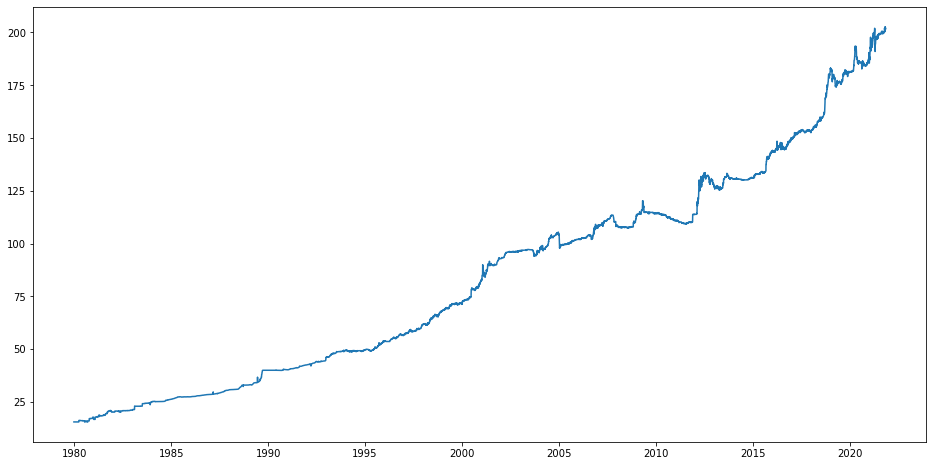

In [18]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.plot(df['Open'], label='Open Price history')

In [19]:
import pandas_ta

# Add EMA to dataframe
df.ta.ema(close='Open', length=10, append=True)

# Normalize the data
df = df[df['EMA_10'].notna()]

# Generate a training and test dataset
x_train, x_test, y_train, y_test = train_test_split(
    df[['Open']], 
    df[['EMA_10']],
    test_size=0.2,
    shuffle=False,
    random_state=69,
)
print("Training Data:")
display(x_train)
display(y_train)
print("Test Data:")
display(x_test)
display(y_test)

model_results = {
    "Model": ["Polynomial Regression"],
    "R^2 Score": [],
}

Training Data:


,Open
Date,
1980-01-09,15.552
1980-01-10,15.552
1980-01-11,15.552
1980-01-14,15.552
1980-01-15,15.552
...,...
2013-09-26,131.900
2013-09-27,131.950
2013-09-30,131.950


,EMA_10
Date,
1980-01-09,15.552000
1980-01-10,15.552000
1980-01-11,15.552000
1980-01-14,15.552000
1980-01-15,15.552000
...,...
2013-09-26,132.147949
2013-09-27,132.111958
2013-09-30,132.082511


Test Data:


,Open
Date,
2013-10-03,131.30
2013-10-04,131.35
2013-10-07,131.10
2013-10-08,131.10
2013-10-09,131.15
...,...
2021-10-28,200.50
2021-10-29,202.00
2021-11-01,202.00


,EMA_10
Date,
2013-10-03,131.830016
2013-10-04,131.742740
2013-10-07,131.625878
2013-10-08,131.530264
2013-10-09,131.461125
...,...
2021-10-28,201.378332
2021-10-29,201.491363
2021-11-01,201.583842


In [20]:
# Use grid search to perform hyperparameter tuning on the polynomial regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

parameters = [{"poly__degree": [2, 3, 4, 5, 6, 7, 8]}]
pipeline = Pipeline(
    steps=[
        ("poly", PolynomialFeatures()),
        ("linear", LinearRegression()),
    ]
)
grid_search = GridSearchCV(
    cv=5,
    estimator=pipeline,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)

# Display the results from the hyperparameter tuning.
degrees = parameters[0]["poly__degree"]
mean_test_scores = grid_search.cv_results_["mean_test_score"]
degrees_tested = pd.DataFrame(
    {"Degree": degrees, "Mean Test Score": mean_test_scores}
)
display(degrees_tested)
best_poly_degree = grid_search.best_params_["poly__degree"]
print(f"Best Polynomial Degree: {best_poly_degree}")
print(f"Best R^2 Score: {grid_search.score(x_test, y_test)}")

,Degree,Mean Test Score
0,2,0.997772
1,3,0.997693
2,4,0.997629
3,5,0.994825
4,6,0.971018
5,7,0.948966
6,8,0.918465


Best Polynomial Degree: 2
Best R^2 Score: 0.9991446965030901


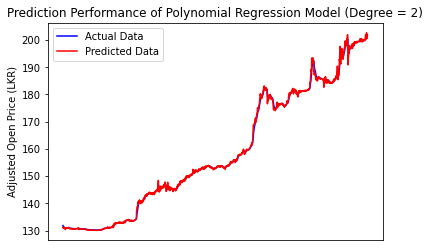

R^2 Score for Polynomial Regression: 0.9991446965030901


In [21]:
# Fit polynomial regression with the optimal degree to the dataset.
poly_reg = PolynomialFeatures(degree=best_poly_degree)
x_train_poly = poly_reg.fit_transform(x_train)

# Define the polynomial regression model.
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
x_test_poly = poly_reg.fit_transform(x_test)
y_pred = poly_model.predict(x_test_poly)

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["EMA_10"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.ylabel("Adjusted Open Price (LKR)")
plt.xticks([])
plt.title(
    "Prediction Performance of Polynomial Regression Model "
    f"(Degree = {best_poly_degree})"
)
plt.legend()
plt.show()

poly_score = poly_model.score(x_test_poly, y_test)
model_results["R^2 Score"].append(poly_score)
print(f"R^2 Score for Polynomial Regression: {poly_score}")